# PixelSkyMatchStep Example Notebook
Author: Varun Bajaj<br>
email: vbajaj@stsci.edu<br>
November 2023

This notebook presents an algorithm to match sky backgrounds when JWST level 3 data (mosaics).  While the default pipeline has a sky matching algorithm already, mosaics with large dithers still show signs of incorrect sky matching, including:
- Background discontinuities near edges of input exposures
- Backgrounds gradients across the mosaic
- Over flagging of pixels in the Outlier Detection step
- Increased noise in the background

Our method fixes these issues by resampling/drizzling (reprojecting) the input images to the same pixel grid (either individually or in groups), allowing for the offsets between overlapping parts of images to be computed on a _per pixel_ basis, which then can be reduced to a mean/median/mode.  In contrast, the default pipeline calculates the average surface brightness of regions that overlap between pairs of images, and takes the difference between these averages.  While subtle, our method appears to calculate the offsets between the overlapping regions more precisely.  These offsets are then used to solve a system of equations for the unknown backgrounds, which can then be subtracted to flatten the sky.

***

 In practice, our method is a "drop-in" replacement for the default pipeline `SkyMatchStep`, and thus should not require much alteration of existing reduction workflows, and has no other software dependencies not already covered by the pipeline!

To actually demonstrate how to use our algorithm, we present a test case which shows poor background matching from the default pipeline, and then an improved version using our method. 

<div class="alert alert-block alert-warning">
<b>NOTE:</b> If you have a non-proprietary data set that shows stronger issues in the sky matching with the default pipeline, please let us know!  Our most extreme cases are still proprietary :(
</div>

## Basic setup

In [1]:
import glob
import matplotlib.pyplot as plt
import os
import shutil

from astroquery.mast import Observations
from astropy.io import fits
from jwst.datamodels import ModelContainer
from jwst.pipeline import calwebb_image2, calwebb_image3
from matplotlib.colors import LogNorm

from jwst_mosaic_skymatch import PixelSkyMatchStep

To keep the code separate from this example dataset, let's make a new directory to hold the example data, and cd into it:

In [2]:
# mv *fits nope/

In [3]:
# Change as desired
home_dir = os.path.expanduser('~')
data_dir = f'{home_dir}/Documents/PixelSkyMatchStep_example_data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

os.chdir(data_dir)

Here, let's download the example data and move it into the current folder

In [ ]:
obs = Observations.query_criteria(obs_id='jw02107-c1019_t018_miri_f2100w')
plist = Observations.get_product_list(obs)
fplist = Observations.filter_products(plist, productSubGroupDescription='RATE')
dl_table = Observations.download_products(fplist)

Move all of the rate images into the current directory

In [ ]:
for im in sorted(glob.glob('./mastDownload/JWST/*/*rate.fits')):
    shutil.move(im, '.')

## Level 2 processing

Before doing the mosaicking, we need to do the thermal background subtraction (separate from the background we are matching in the level 3 stage of the pipeline to make the mosaic).  

<div class="alert alert-block alert-warning">
<b>Note:</b> If you are using a different dataset, you need to choose the appropriate background exposures for the data you're looking at!  Specfically, change the line below defining `bkg_list` to select the right background exposures for your target.
</div>

In [ ]:
bkg_list = sorted(glob.glob('jw0210704*rate.fits'))

In [ ]:
bkg_list

In [ ]:
def do_level_2(rate_im):
    """Runs the level 2 pipeline with the background subtraction step"""
    im2_pipe = calwebb_image2.Image2Pipeline()
    im2_pipe.bkg_subtract.sigma = 2.5
    res = im2_pipe.bkg_subtract(rate_im, bkg_list)

    im2_pipe.bkg_subtract.skip = True
    im2_pipe.resample.skip = True

    im2_pipe.suffix = 'cal'
    im2_pipe.save_results = True
    im2_pipe.run(res)

<div class="alert alert-block alert-warning">
<b>Note:</b> If you are using a different dataset, you need to choose the appropriate target exposures for the data you're looking at!  Specfically, change the line for the loop below to select the right target exposures.
</div>

In [ ]:
for rate_im in sorted(glob.glob('jw0210703*rate.fits')):
    do_level_2(rate_im)

## Default Level 3 Processing

In [ ]:
cal_ims = ModelContainer(sorted(glob.glob('*cal.fits')))

First, let's just align the images (you will likely need to change the parameters for different datasets):

In [ ]:
im3_pipe = calwebb_image3.Image3Pipeline()
im3_pipe.tweakreg.expand_refcat = False
im3_pipe.tweakreg.kernel_fwhm = 4.5
im3_pipe.tweakreg.fitgeometry = 'general'
im3_pipe.tweakreg.snr_threshold = 2.
im3_pipe.tweakreg.abs_refcat = 'GAIADR3'
aligned_mc = im3_pipe.tweakreg.run(cal_ims)

In [ ]:
im3_pipe.tweakreg.skip = True

im3_pipe.skymatch.skystat = 'median'
im3_pipe.skymatch.skymethod = 'match'

im3_pipe.outlier_detection.save_results=False
im3_pipe.outlier_detection.save_intermediate_results = False

im3_pipe.resample.output_file = 'default_pipeline_i2d.fits'
im3_pipe.resample.save_results = True

im3_pipe.source_catalog.skip = True

# copy
im3_pipe.run(aligned_mc.copy())

## Level 3 Processing with PixelSkyMatchStep

`PixelSkyMatchStep` works similarly to the default `SkyMatchStep` of the JWST Pipeline, and as such the interface is familiar, alebit currently offers fewer options

In [ ]:
print(PixelSkyMatchStep.spec)

By default, `PixelSkyMatchStep` will still use the default pipeline method to calculate offsets between exposures in the same visit (see `PixelSkyMatchStep.grouping`), as the pipeline does reasonably well within the visit since the dithers between data are not large.  Thus, images taken in the same visit are "grouped" by default and drizzled together, and the offsets are calculated between the grouped drizzled images.  The resultant backgrounds are then added to the "intra-visit" backgrounds calculated before drizzling, and the pipeline continues as usual 

Additionally, when calculating the background levels, the overlap between the images is used to weight the rows in the system of equations.  If, for some reason that is not desired, `PixelSkyMatchStep.weight` can be set to `False`.

In [ ]:
im3_pipe = calwebb_image3.Image3Pipeline()
im3_pipe.tweakreg.skip = True

# Set the whole skymatch attribute to `PixelSkyMatchStep()`
im3_pipe.skymatch = PixelSkyMatchStep()
im3_pipe.skymatch.skymethod = 'match'
im3_pipe.skymatch.skystat = 'median'
im3_pipe.skymatch.weight = True
im3_pipe.skymatch.grouping = 'visit' # all images in a visit will be grouped and drizzled together first

im3_pipe.outlier_detection.save_results=False
im3_pipe.outlier_detection.save_intermediate_results = False

im3_pipe.resample.output_file = 'enhanced_pipeline_i2d.fits'
im3_pipe.resample.save_results = True

im3_pipe.source_catalog.skip = True

im3_pipe.run(aligned_mc.copy())

In some cases, you may want to calculate the offsets for every exposure separately.  To do that, you can set PixelSkyMatchStep.grouping to `None`

In [ ]:
im3_pipe = calwebb_image3.Image3Pipeline()

im3_pipe.tweakreg.skip = True

im3_pipe.skymatch = pixel_skymatch_step.PixelSkyMatchStep()
im3_pipe.skymatch.skymethod = 'match'
im3_pipe.skymatch.skystat = 'median'
im3_pipe.skymatch.weight = True
im3_pipe.skymatch.grouping = None # Each image will be drizzled and treated separately

im3_pipe.outlier_detection.save_results=False
im3_pipe.outlier_detection.save_intermediate_results = False

im3_pipe.resample.output_file = 'enhanced_no_grouping_pipeline_i2d.fits'
im3_pipe.resample.save_results = True

im3_pipe.source_catalog.skip = True

im3_pipe.run(aligned_mc.copy())

Let's finish by taking a look at the data.  If using the default dataset for this notebook, comparing the spiral arms in the upper left shows the left half of the image having a noticeably different background than the right.  However, using `PixelSkyMatchStep` makes it much more even.  The effect can be hard to see in the notebook, so opening the images in ds9 or similar (perhaps Jdaviz) makes it more obvious.  In January 2024, this notebook will be updated with a more obvious case, once the input data becomes public.

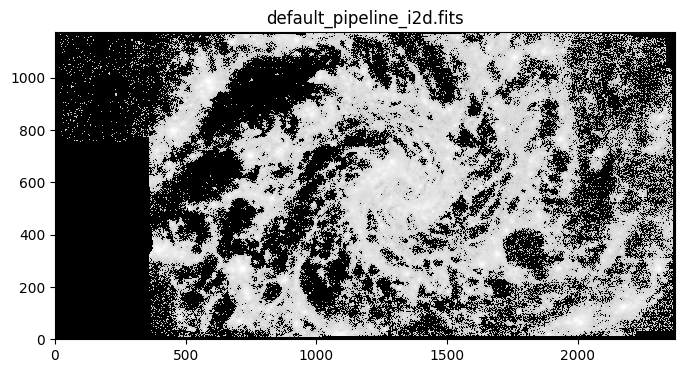

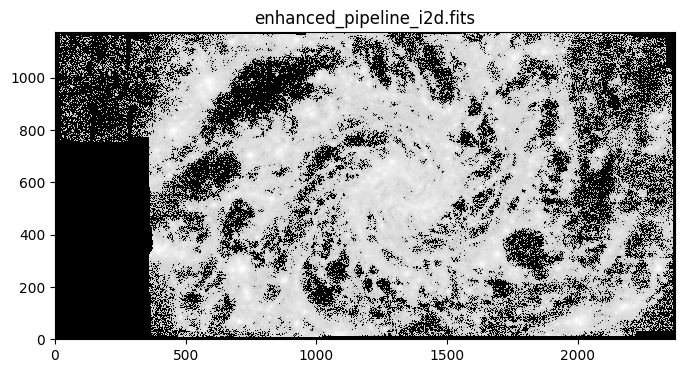

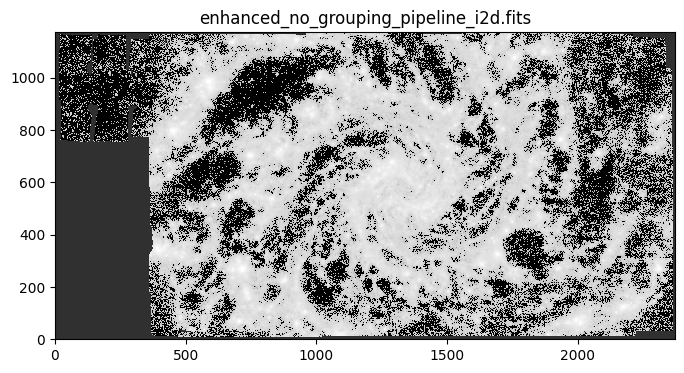

In [4]:
i2ds = ['default_pipeline_i2d.fits', 'enhanced_pipeline_i2d.fits', 'enhanced_no_grouping_pipeline_i2d.fits']
for i2d in i2ds:
    data = fits.getdata(i2d)
    fig = plt.figure(figsize=(8,16))
    # Set the vmin/vmax to the appropriate levels for your data
    plt.imshow(data, norm=LogNorm(vmin=-.5, vmax=140, clip=True), origin='lower', cmap='Greys_r', interpolation='none')
    plt.title(i2d)

We would love to hear your thoughts on this method, and contributions are certainly welcome!  Please do not hesitate to reach out to vbajaj@stsci.edu with questions or comments!  Also, bear with us if there are edge cases and bugs, this package is still very much so in development!

***

<img style="float: center;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>